In [141]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [142]:
initial_image_png = "cropped_image.png"
points = np.genfromtxt('points.csv', delimiter=',', names=True)

# convert points to float tuples
points = [(float(x), float(y)) for x, y in points]
points = np.array(points)

points

array([[ 0.,  0.],
       [ 5.,  0.],
       [ 0., -4.],
       [-3.,  0.],
       [ 0.,  2.],
       [-7., -4.],
       [ 5., -7.],
       [ 8.,  2.],
       [-4.,  4.],
       [-3., -5.],
       [ 3., -4.],
       [ 3.,  6.],
       [ 2.,  2.],
       [-8.,  2.]])

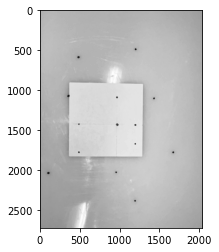

In [143]:
img = cv.imread(initial_image_png, cv.IMREAD_GRAYSCALE)

img = cv.medianBlur(img, 15)

plt.imshow(img, cmap="gray")

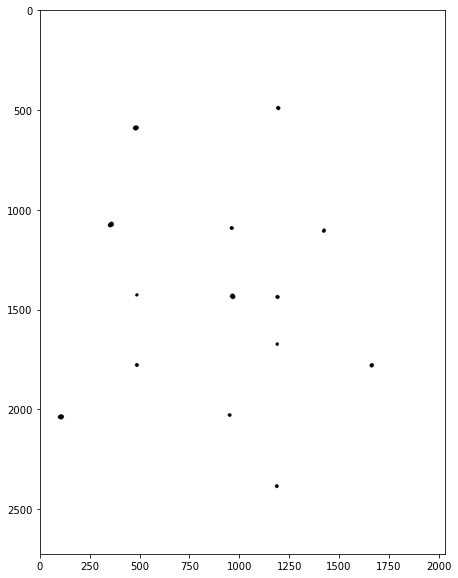

In [144]:
thresh, bwImage = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
# set the height of the plot to 10 inches

plt.figure(figsize=(10, 10))
plt.imshow(bwImage, cmap="gray")

In [145]:
params = cv.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 50

# params.filterByArea = True
params.minArea = 10

# # Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# # Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# # Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.1


detector = cv.SimpleBlobDetector_create(params)
keypoints = detector.detect(bwImage)
len(keypoints)

14

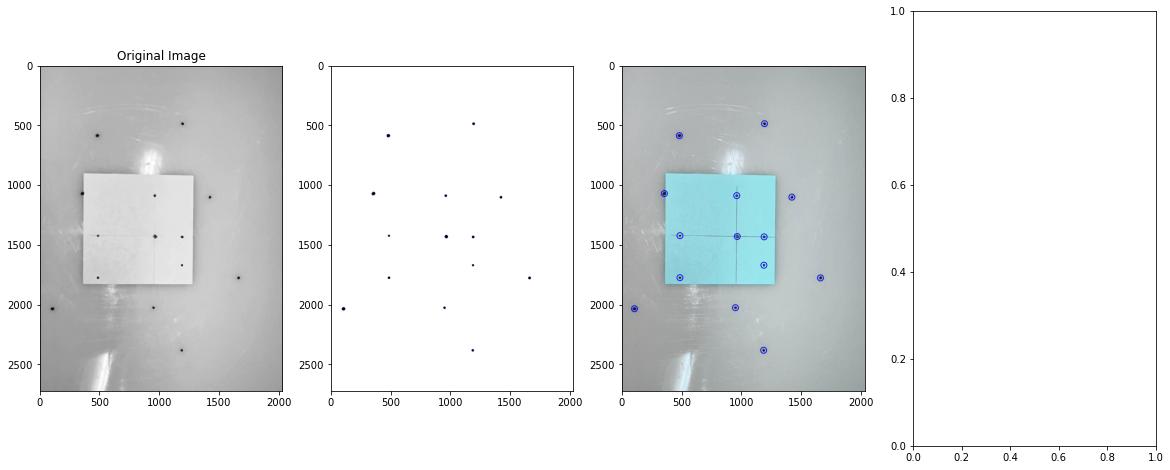

In [146]:
im_with_keypoints = cv.drawKeypoints(bwImage, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
circleImg = np.ones((bwImage.shape)) * 255
found_point_centers = []

for i, keypoint in enumerate(keypoints):
    center = (int(keypoint.pt[0]), int(keypoint.pt[1]))
    found_point_centers.append(center)
    cv.circle(circleImg, center, 25, 0, -1)

colored_img = cv.imread(initial_image_png, cv.IMREAD_COLOR)

# Draw a circle around each found point with 25% transparency
for i, found_point in enumerate(found_point_centers):
    cv.circle(colored_img, found_point, 25, (0, 0, 255, 10), 5)

plt.subplots(1, 4, figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(im_with_keypoints)

plt.subplot(1, 4, 3)
plt.imshow(colored_img)


We now need to map each found point to one of the points in points 

In [187]:
# Map each point to the closest found point, knowing that points may be in different order
# and that the image is likely to be rotated and perspective distorted

# Find the euclidean distances between each point and other points
# make a np array of the distances

points_dists = np.zeros((len(points), len(points)))
for i, point in enumerate(points):
    for j, other_point in enumerate(points):
        points_dists[i, j] = np.linalg.norm(np.array(point) - np.array(other_point))

found_point_dists = np.zeros((len(found_point_centers), len(found_point_centers)))
for i, point in enumerate(found_point_centers):
    for j, other_point in enumerate(found_point_centers):
        found_point_dists[i, j] = np.linalg.norm(np.array(point) - np.array(other_point))

# For each point, find a unique distance index, calculated as the sum of the distances
# to all other points
point_dist_value = np.zeros(len(points))
for i, point in enumerate(points):
    point_dist_value[i] = np.sum(np.power(points_dists[i], 3))

found_point_dist_value = np.zeros(len(found_point_centers))
for i, point in enumerate(found_point_centers):
    found_point_dist_value[i] = np.sum(np.power(found_point_dists[i], 3))


# Normalize the distances
point_dist_value = point_dist_value / np.max(point_dist_value)
found_point_dist_value = found_point_dist_value / np.max(found_point_dist_value)

# apply linear sum assignment to find the best mapping
from scipy.optimize import linear_sum_assignment

original_point_index, found_point_index = linear_sum_assignment(np.abs(point_dist_value[:, None] - found_point_dist_value[None, :]))

original_point_index, found_point_index

<ipython-input-187-57a855e4fac1>:25: RuntimeWarning: overflow encountered in power
  found_point_dist_value[i] = np.sum(2 ** found_point_dists[i])
<ipython-input-187-57a855e4fac1>:30: RuntimeWarning: invalid value encountered in true_divide
  found_point_dist_value = found_point_dist_value / np.max(found_point_dist_value)


ValueError: matrix contains invalid numeric entries

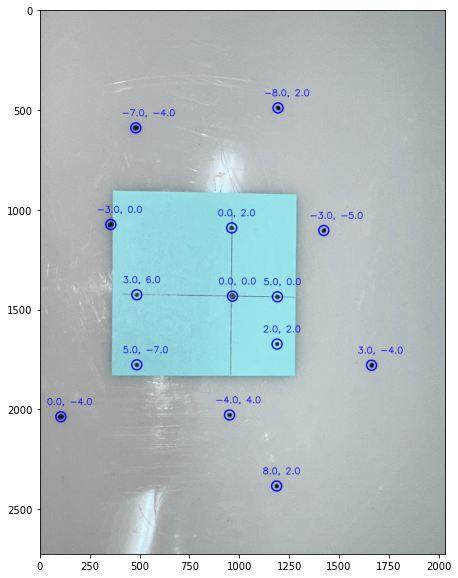

In [186]:
# On a color image, draw the coordinates of the original points on the found points

color_img = cv.imread(initial_image_png, cv.IMREAD_COLOR)

for i, found_point in enumerate(found_point_centers):
    text_point = (int(found_point[0] - 70), int(found_point[1] - 60))

    # use a white background for the text
    text = f"{points[found_point_index[i]][0]}, {points[found_point_index[i]][1]}"

    cv.putText(color_img, text, text_point, cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2, cv.LINE_AA)

    # draw a circle around the found point
    cv.circle(color_img, found_point, 25, (0, 0, 255, 10), 5)

# make image size 10 inches by 10 inches
plt.figure(figsize=(10, 10))
plt.imshow(color_img)

